# Sentiment analysis

In [2]:
import urllib.request
import pickle
import numpy as np
import matplotlib.pyplot as plt
from utils_globals import *
from utils_sentiment_tfidf import *
from collections import Counter

# Load graph:
S = pickle.load(open(PICKLE_DIR + "/graph.pkl", "rb"))
S_undirected = pickle.load(open(PICKLE_DIR + "/graph_undirected.pkl", "rb"))

In [3]:
# Download the LabMT wordlist (with happiness scores)
file_id = "1fEW8gxKEfwiNRgpeqQ1S9qbATyrNftoE"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
local_filename = "labmt_wordlist.txt"
urllib.request.urlretrieve(url, local_filename)

('labmt_wordlist.txt', <http.client.HTTPMessage at 0x2949fc93990>)

In [4]:
# Load the LabMT wordlist into memory
labmt_wordlist = load_labmt_wordlist(local_filename)

In [5]:
process_graph(S_undirected, labmt_wordlist)

# What the nodes look like now
print(list(S_undirected.nodes(data=True))[256])


Total artists processed: 1366 out of 1366
('Roy_Wood_Sellars', {'contentlength': 271, 'sentiment': 5.557209302325583})


## Some statistics

In [6]:
# Collect all valid sentiment scores from the graph
sentiment_scores = [
    S_undirected.nodes[node]["sentiment"]
    for node in S_undirected.nodes
    if S_undirected.nodes[node]["sentiment"] is not None
]

# Calculate key statistics
mean_sentiment = np.mean(sentiment_scores)
median_sentiment = np.median(sentiment_scores)
variance_sentiment = np.var(sentiment_scores)
percentile_25 = np.percentile(sentiment_scores, 25)
percentile_75 = np.percentile(sentiment_scores, 75)

# Print the statistics
print(f"Mean: {mean_sentiment:.2f}")
print(f"Median: {median_sentiment:.2f}")
print(f"Variance: {variance_sentiment:.2f}")
print(f"25th Percentile: {percentile_25:.2f}")
print(f"75th Percentile: {percentile_75:.2f}")

Mean: 5.42
Median: 5.41
Variance: 0.01
25th Percentile: 5.37
75th Percentile: 5.46


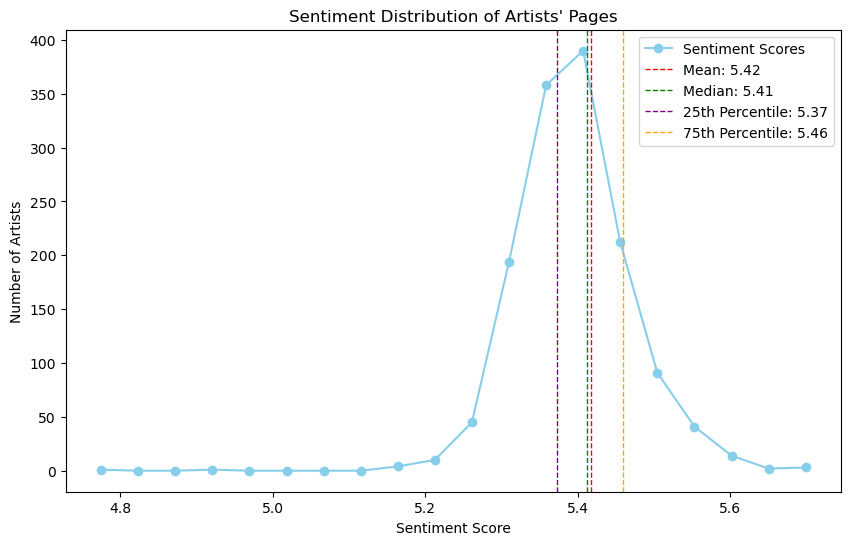

In [7]:
# A graph to represent the distribution of sentiment scores
bins = np.linspace(min(sentiment_scores), max(sentiment_scores), 21)  # 20 bins
hist_values, bin_edges = np.histogram(sentiment_scores, bins=bins)

plt.figure(figsize=(10, 6))
plt.plot(bin_edges[:-1], hist_values, marker='o', color='skyblue', linestyle='-', label="Sentiment Scores")

plt.axvline(mean_sentiment, color='red', linestyle='dashed', linewidth=1, label=f"Mean: {mean_sentiment:.2f}")
plt.axvline(median_sentiment, color='green', linestyle='dashed', linewidth=1, label=f"Median: {median_sentiment:.2f}")
plt.axvline(percentile_25, color='purple', linestyle='dashed', linewidth=1, label=f"25th Percentile: {percentile_25:.2f}")
plt.axvline(percentile_75, color='orange', linestyle='dashed', linewidth=1, label=f"75th Percentile: {percentile_75:.2f}")

plt.xlabel("Sentiment Score")
plt.ylabel("Number of Artists")
plt.title("Sentiment Distribution of Artists' Pages")
plt.legend()
plt.show()

In [8]:
# Sort nodes by sentiment score to find happiest and saddest philosophers
sorted_sentiment = sorted(
    [(node, S_undirected.nodes[node]["sentiment"]) for node in S_undirected.nodes if S_undirected.nodes[node]["sentiment"] is not None],
    key=lambda x: x[1],
    reverse=True
)

# Get the top 4 happiest and saddest philosophers
happiest_philosophes = sorted_sentiment[:4]
saddest_philosophers = sorted_sentiment[-4:]

# Print the results
print("Top 4 Happiest Philosophers:")
for artist, score in happiest_philosophes:
    print(f"{artist}: {score:.2f}")

print("\nTop 4 Saddest Philosophers:")
for artist, score in saddest_philosophers:
    print(f"{artist}: {score:.2f}")

Top 4 Happiest Philosophers:
The_Oxford_Companion_to_Philosophy: 5.75
The_Cambridge_Dictionary_of_Philosophy: 5.72
Ram_Gopal_Varma: 5.71
Richard_Schacht: 5.68

Top 4 Saddest Philosophers:
Hervaeus_Natalis: 5.19
Heinrich_Rickert: 5.17
Dietrich_of_Freiberg: 4.94
Stanislaw_Lesniewski: 4.78


## Community sentiment analysis

In [9]:
# Load the subfields partitions
subfields_partition = pickle.load(open(PICKLE_DIR + "/subfields_partition.pkl", "rb"))
tradition_partition = pickle.load(open(PICKLE_DIR + "/louvain_partition_subfields.pkl", "rb"))

# Load the tradition partitions
tradition_partition = pickle.load(open(PICKLE_DIR + "/tradition_partition.pkl", "rb"))
louvain_partition_tradition = pickle.load(open(PICKLE_DIR + "/louvain_partition_tradition.pkl", "rb"))

In [10]:
# For the partition based on SUBFIELDS
# Identify the 10 largest communities by size for focused analysis
community_sizes = Counter(subfields_partition.values())
print(community_sizes)
largest_communities1 = [community for community, _ in community_sizes.most_common(10)]
print("The 10 largest communities are:", largest_communities1)

# Calculate sentiment for each of the 10 largest communities
community_sentiments = {}
for community_id in largest_communities1:
    avg_sentiment = calculate_community_sentiment(S_undirected, community_id, subfields_partition)
    community_sentiments[community_id] = avg_sentiment
sorted_community_sentiments = sorted(community_sentiments.items(), key=lambda x: x[1], reverse=True)

print("\nCommunities sorted by average sentiment:")
for community_id, avg_sentiment in sorted_community_sentiments:
    print(f"Community {community_id}: Avg Sentiment = {avg_sentiment:.3f}")

Counter({'ethicists': 77, 'logicians': 72, 'metaphysicians': 68, 'epistemologists': 66, 'sociopolitical thinkers': 57, 'aestheticians': 51, 'critical theorists': 38, 'political philosophers': 30, 'philosophers of language': 25, 'philosophers of science': 18, 'philosophers of religion': 18, 'philosophers of mind': 17, 'feminist philosophers': 16, 'secular humanists': 14, 'political theorists': 8, 'utilitarians': 7, 'phenomenologists': 6, 'environmental philosophers': 6, 'existentialists': 1})
The 10 largest communities are: ['ethicists', 'logicians', 'metaphysicians', 'epistemologists', 'sociopolitical thinkers', 'aestheticians', 'critical theorists', 'political philosophers', 'philosophers of language', 'philosophers of science']

Communities sorted by average sentiment:
Community philosophers of language: Avg Sentiment = 5.492
Community philosophers of science: Avg Sentiment = 5.444
Community critical theorists: Avg Sentiment = 5.438
Community aestheticians: Avg Sentiment = 5.435
Comm

In [11]:
# For the partition based on TRADITION
# Identify the communities
community_sizes = Counter(tradition_partition.values())
print(community_sizes)
largest_communities2 = [community for community, _ in community_sizes.most_common(3)]
print("The communities are:", largest_communities2)

# Calculate sentiment for each of the communities
community_sentiments = {}
for community_id in largest_communities2:
    avg_sentiment = calculate_community_sentiment(S_undirected, community_id, tradition_partition)
    community_sentiments[community_id] = avg_sentiment
    print(f"Community {community_id}: Avg Sentiment = {avg_sentiment:.3f}")

Counter({'Western philosophers': 278, 'Eastern philosophers': 68})
The communities are: ['Western philosophers', 'Eastern philosophers']
Community Western philosophers: Avg Sentiment = 5.412
Community Eastern philosophers: Avg Sentiment = 5.415


We can also identify the **three most connected nodes** (philosophers) in each community of the partition based on the subfields.

In [12]:
community_sizes = Counter(subfields_partition.values())  
largest_communities = [community for community, _ in community_sizes.most_common(10)]

# Find top 3 connected characters for each of the 10 largest communities
top_philosophers_per_community = {}
for community_id in largest_communities:
    top_philosophers = get_top_connected_characters(S_undirected, community_id, subfields_partition)
    top_philosophers_per_community[community_id] = top_philosophers
    print(f"Community {community_id}: Top 3 characters = {top_philosophers}")

Community ethicists: Top 3 characters = ['Martin_Heidegger', 'John_Stuart_Mill', 'Adam_Smith']
Community logicians: Top 3 characters = ['Gottlob_Frege', 'Simplicius_of_Cilicia', 'Alfred_North_Whitehead']
Community metaphysicians: Top 3 characters = ['Henri_Bergson', 'Pythagoras', 'Duns_Scotus']
Community epistemologists: Top 3 characters = ['René_Descartes', 'John_Locke', 'Bertrand_Russell']
Community sociopolitical thinkers: Top 3 characters = ['Cicero', 'Voltaire', 'Louis_Althusser']
Community aestheticians: Top 3 characters = ['Aristotle', 'Immanuel_Kant', 'Plato']
Community critical theorists: Top 3 characters = ['Jürgen_Habermas', 'Paul_Feyerabend', 'Henri_Lefebvre']
Community political philosophers: Top 3 characters = ['Martin_Luther', 'Leon_Trotsky', 'Thomas_Jefferson']
Community philosophers of language: Top 3 characters = ['Gilbert_Ryle', 'Donald_Davidson_(philosopher)', 'Michael_Dummett']
Community philosophers of science: Top 3 characters = ['Galileo_Galilei', 'Ernst_Mach', 

**Top three** happiest and saddest communities.

In [13]:
community_sentiments = {}
for community_id in largest_communities1:
    avg_sentiment = calculate_community_sentiment(S_undirected, community_id, subfields_partition)
    community_sentiments[community_id] = avg_sentiment
sorted_communities = sorted(community_sentiments.items(), key=lambda x: x[1], reverse=True)

# Identify the top 3 happiest and saddest communities
happiest_communities = sorted_communities[:3]
saddest_communities = sorted_communities[-3:]

print("\nHappiest Communities:")
for community_id, sentiment in happiest_communities:
    top_philosophers = top_philosophers_per_community[community_id]
    print(f"Community {community_id} (Top philosophers: {top_philosophers}): Avg Sentiment = {sentiment:.2f}")

print("\nSaddest Communities:")
for community_id, sentiment in saddest_communities:
    top_philosophers = top_philosophers_per_community[community_id]
    print(f"Community {community_id} (Top characters: {top_philosophers}): Avg Sentiment = {sentiment:.2f}")


Happiest Communities:
Community philosophers of language (Top philosophers: ['Gilbert_Ryle', 'Donald_Davidson_(philosopher)', 'Michael_Dummett']): Avg Sentiment = 5.49
Community philosophers of science (Top philosophers: ['Galileo_Galilei', 'Ernst_Mach', 'Gaston_Bachelard']): Avg Sentiment = 5.44
Community critical theorists (Top philosophers: ['Jürgen_Habermas', 'Paul_Feyerabend', 'Henri_Lefebvre']): Avg Sentiment = 5.44

Saddest Communities:
Community political philosophers (Top characters: ['Martin_Luther', 'Leon_Trotsky', 'Thomas_Jefferson']): Avg Sentiment = 5.40
Community metaphysicians (Top characters: ['Henri_Bergson', 'Pythagoras', 'Duns_Scotus']): Avg Sentiment = 5.40
Community sociopolitical thinkers (Top characters: ['Cicero', 'Voltaire', 'Louis_Althusser']): Avg Sentiment = 5.40


Finally a **graph** to compare the average sentiment.

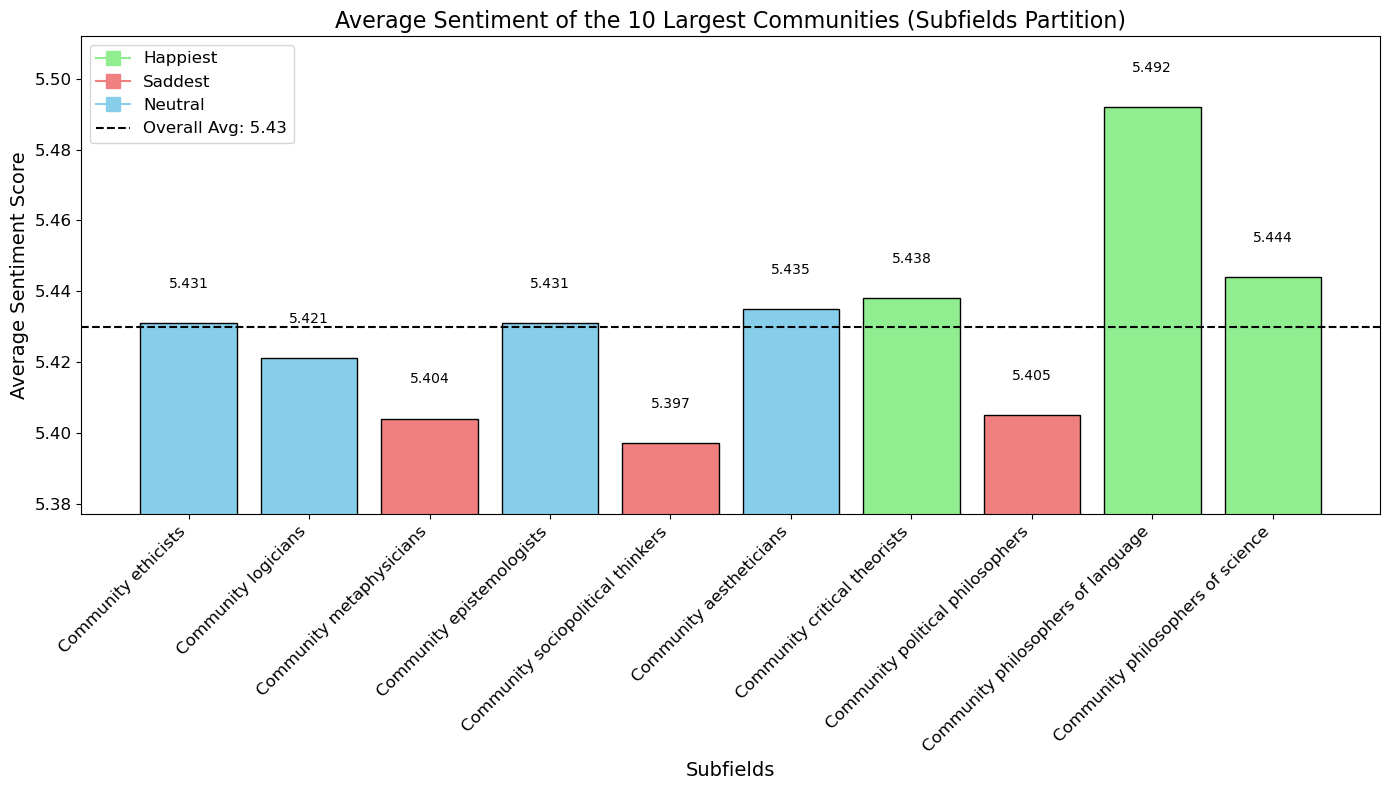

In [21]:
import numpy as np

# Round average sentiments to two decimal places
average_sentiments = [round(community_sentiments[c], 3) for c in largest_communities]

# Prepare data for plotting
community_ids = [f"Community {c}" for c in largest_communities]

# Assign colors based on sentiment
colors = []
for community_id in largest_communities:
    if community_id in [c[0] for c in happiest_communities]:
        colors.append('lightgreen')  # Happiest communities in green
    elif community_id in [c[0] for c in saddest_communities]:
        colors.append('lightcoral')  # Saddest communities in red
    else:
        colors.append('skyblue')  # Neutral color for other communities

# Compute the average sentiment line across all communities
overall_average_sentiment = np.mean(average_sentiments)

# Create a bar plot
plt.figure(figsize=(14, 8))  # Adjust figure size for better visibility

# Plot the bars with color-coded bars for happiest and saddest communities
bars = plt.bar(community_ids, average_sentiments, color=colors, edgecolor='black', label='Average Sentiment')

# Annotate bars with rounded sentiment values
for bar, sentiment in zip(bars, average_sentiments):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f"{sentiment:.3f}", ha='center', fontsize=10)

# Add the overall average sentiment line
plt.axhline(y=overall_average_sentiment, color='black', linestyle='--', linewidth=1.5, label=f'Overall Avg: {overall_average_sentiment:.2f}')

# Adjust the y-axis to focus on differences
plt.ylim(min(average_sentiments) - 0.02, max(average_sentiments) + 0.02)

# Label the axes and add a title
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Subfields", fontsize=14)
plt.ylabel("Average Sentiment Score", fontsize=14)
plt.title("Average Sentiment of the 10 Largest Communities (Subfields Partition)", fontsize=16)

# Add legend for color-coded bars and average sentiment
handles = [
    plt.Line2D([0], [0], color='lightgreen', marker='s', markersize=10, label='Happiest'),
    plt.Line2D([0], [0], color='lightcoral', marker='s', markersize=10, label='Saddest'),
    plt.Line2D([0], [0], color='skyblue', marker='s', markersize=10, label='Neutral'),
    plt.Line2D([0], [0], color='black', linestyle='--', linewidth=1.5, label=f'Overall Avg: {overall_average_sentiment:.2f}'),
]
plt.legend(handles=handles, fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()
